# Détection de Fraude Bancaire avec Machine Learning

## Contexte
Mettre en place une solution IA qui permet d'automatiser l'identification des clients frauduleux pour les entreprises bancaires. Cette solution permettra de gagner plus de temps et de minimiser les risques de fraude a priori.

## Objectifs
Mettre en place un modèle d'IA basé sur les modèles de machine Learning pour identifier a priori les cas de fraude bancaire.

## Description des variables
- Le jeu de données contient 2266 observations et 14 variables
- La variable de sortie est `PotentialFraud`

In [36]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
import joblib
import pickle
from datetime import datetime
import os

import json

warnings.filterwarnings('ignore')

# Importation des modèles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Tâche 1 : Chargement des données


In [8]:
# Chargement des données depuis le fichier CSV
df = pd.read_csv('creditcarddata.csv')

# Affichage des informations de base sur le dataset
print("Informations sur le dataset :")
print(f"Nombre d'observations : {df.shape[0]}")
print(f"Nombre de variables : {df.shape[1]}")
print("\nPremières lignes du dataset :")
df.head()


Informations sur le dataset :
Nombre d'observations : 2266
Nombre de variables : 14

Premières lignes du dataset :


,Gender,Age,HouseTypeID,ContactAvaliabilityID,HomeCountry,AccountNo,CardExpiryDate,TransactionAmount,TransactionCountry,LargePurchase,ProductID,CIF,TransactionCurrencyCode,PotentialFraud
0,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
1,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
2,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
3,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
4,0,56,1,0,1,1109976,1811,1.0354,1,0,3,11020290,1,0


In [5]:
# Vérification des types de données et des valeurs manquantes
print("Types de données :")
print(df.dtypes)
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


Types de données :
Gender                       int64
Age                          int64
HouseTypeID                  int64
ContactAvaliabilityID        int64
HomeCountry                  int64
AccountNo                    int64
CardExpiryDate               int64
TransactionAmount          float64
TransactionCountry           int64
LargePurchase                int64
ProductID                    int64
CIF                          int64
TransactionCurrencyCode      int64
PotentialFraud               int64
dtype: object

Valeurs manquantes par colonne :
Gender                     0
Age                        0
HouseTypeID                0
ContactAvaliabilityID      0
HomeCountry                0
AccountNo                  0
CardExpiryDate             0
TransactionAmount          0
TransactionCountry         0
LargePurchase              0
ProductID                  0
CIF                        0
TransactionCurrencyCode    0
PotentialFraud             0
dtype: int64


## Tâche 2 : Modèles de Classification pour la Détection de Fraude

- Régression Logistique
- Arbre de Décision
- Forêt Aléatoire (Random Forest)
- Gradient Boosting (XGBoost, LightGBM, CatBoost)
- Support Vector Machine (SVM)
- Naive Bayes
- k-Nearest Neighbors (k-NN)
- Voting Classifier
- Stacking
- Bagging
- Réseaux de Neurones (ANN)
- Réseaux Profonds


## Tâche 3 : Préparation des données


In [9]:
# 1. Vérification des valeurs manquantes
print("=== VÉRIFICATION DES VALEURS MANQUANTES ===")
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())
print(f"\nTotal des valeurs manquantes : {df.isnull().sum().sum()}")
print(f"Pourcentage de valeurs manquantes : {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")


=== VÉRIFICATION DES VALEURS MANQUANTES ===
Valeurs manquantes par colonne :
Gender                     0
Age                        0
HouseTypeID                0
ContactAvaliabilityID      0
HomeCountry                0
AccountNo                  0
CardExpiryDate             0
TransactionAmount          0
TransactionCountry         0
LargePurchase              0
ProductID                  0
CIF                        0
TransactionCurrencyCode    0
PotentialFraud             0
dtype: int64

Total des valeurs manquantes : 0
Pourcentage de valeurs manquantes : 0.00%


In [10]:
# 2. Vérification des doublons
print("=== VÉRIFICATION DES DOUBLONS ===")
print(f"Nombre de doublons : {df.duplicated().sum()}")
print(f"Pourcentage de doublons : {(df.duplicated().sum() / len(df)) * 100:.2f}%")

if df.duplicated().sum() > 0:
    print("\nSuppression des doublons...")
    df = df.drop_duplicates()
    print(f"Dataset après suppression des doublons : {df.shape}")
else:
    print("Aucun doublon trouvé.")


=== VÉRIFICATION DES DOUBLONS ===
Nombre de doublons : 933
Pourcentage de doublons : 41.17%

Suppression des doublons...
Dataset après suppression des doublons : (1333, 14)


In [11]:
# 3. Vérification des valeurs aberrantes
print("=== VÉRIFICATION DES VALEURS ABERRANTES ===")
print("Statistiques descriptives des variables numériques :")
print(df.describe())

# Détection des valeurs aberrantes avec la méthode IQR
numeric_columns = df.select_dtypes(include=[np.number]).columns
outliers_info = {}

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_info[col] = len(outliers)
    
    print(f"\n{col}:")
    print(f"  - Valeurs aberrantes : {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print(f"  - Bornes : [{lower_bound:.2f}, {upper_bound:.2f}]")


=== VÉRIFICATION DES VALEURS ABERRANTES ===
Statistiques descriptives des variables numériques :
            Gender          Age  HouseTypeID  ContactAvaliabilityID  \
count  1333.000000  1333.000000  1333.000000            1333.000000   
mean      0.308327    32.794449     0.451613               1.078020   
std       0.461976    18.060286     0.497840               0.850669   
min       0.000000     2.000000     0.000000               0.000000   
25%       0.000000    17.000000     0.000000               0.000000   
50%       0.000000    33.000000     0.000000               1.000000   
75%       1.000000    50.000000     1.000000               2.000000   
max       1.000000    63.000000     1.000000               2.000000   

       HomeCountry     AccountNo  CardExpiryDate  TransactionAmount  \
count       1333.0  1.333000e+03     1333.000000        1333.000000   
mean           1.0  7.432076e+06     2074.357089          44.566642   
std            0.0  1.305522e+06       61.978249  

=== VÉRIFICATION DU DÉSÉQUILIBRE DE CLASSE ===
Distribution de la variable cible 'PotentialFraud':
PotentialFraud
0    1185
1     148
Name: count, dtype: int64

Pourcentages:
PotentialFraud
0    88.897224
1    11.102776
Name: proportion, dtype: float64


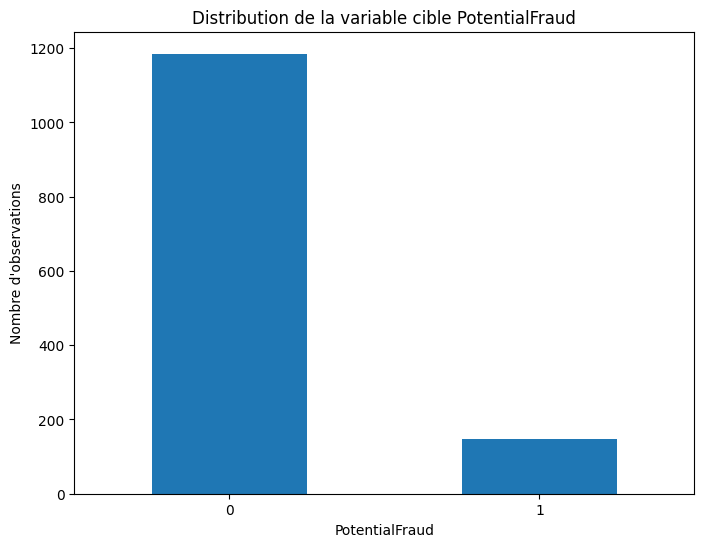


Ratio de déséquilibre : 8.01
 Déséquilibre de classe détecté !


In [12]:
# 4. Vérification du déséquilibre de classe
print("=== VÉRIFICATION DU DÉSÉQUILIBRE DE CLASSE ===")
print("Distribution de la variable cible 'PotentialFraud':")
print(df['PotentialFraud'].value_counts())
print(f"\nPourcentages:")
print(df['PotentialFraud'].value_counts(normalize=True) * 100)

# Visualisation du déséquilibre
plt.figure(figsize=(8, 6))
df['PotentialFraud'].value_counts().plot(kind='bar')
plt.title('Distribution de la variable cible PotentialFraud')
plt.xlabel('PotentialFraud')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=0)
plt.show()

# Calcul du ratio de déséquilibre
class_counts = df['PotentialFraud'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de déséquilibre : {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print(" Déséquilibre de classe détecté !")
else:
    print(" Classes relativement équilibrées")


In [17]:
# 5. Correction des problèmes détectés

print("=== CORRECTION DES PROBLÈMES ===")

# Correction des valeurs manquantes (si présentes)
if df.isnull().sum().sum() > 0:
    print("Traitement des valeurs manquantes...")
    # Pour les variables numériques : remplacer par la médiane
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    # Pour les variables catégorielles : remplacer par le mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    print(" Valeurs manquantes traitées")
else:
    print(" Aucune valeur manquante à traiter")

# Correction du déséquilibre de classe 
if imbalance_ratio > 2:
    print(f"\nCorrection du déséquilibre de classe (ratio: {imbalance_ratio:.2f})...")
    
    # Identifier les classes
    class_counts = df['PotentialFraud'].value_counts()
    majority_class = class_counts.index[0]
    minority_class = class_counts.index[1]
    
    # Séparer les données
    df_majority = df[df['PotentialFraud'] == majority_class]
    df_minority = df[df['PotentialFraud'] == minority_class]
    
    # Oversampling de la classe minoritaire
    df_minority_upsampled = resample(df_minority,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)
    
    # Combiner les datasets
    df_balanced = pd.concat([df_majority, df_minority_upsampled])
    
    print(f"Dataset original : {df.shape}")
    print(f"Dataset équilibré : {df_balanced.shape}")
    print("\nNouvelle distribution :")
    print(df_balanced['PotentialFraud'].value_counts())
    
    # Remplacer le dataset original par le dataset équilibré
    df = df_balanced.copy()
    print("Déséquilibre de classe corrigé avec oversampling")
else:
    print("Aucune correction nécessaire pour le déséquilibre de classe")

=== CORRECTION DES PROBLÈMES ===
 Aucune valeur manquante à traiter

Correction du déséquilibre de classe (ratio: 8.01)...
Dataset original : (1333, 14)
Dataset équilibré : (2370, 14)

Nouvelle distribution :
PotentialFraud
0    1185
1    1185
Name: count, dtype: int64
Déséquilibre de classe corrigé avec oversampling


In [ ]:
# 6. Résumé final de la préparation des données
print("=== RÉSUMÉ FINAL DE LA PRÉPARATION DES DONNÉES ===")
print(f"Dataset final : {df.shape}")
print(f"Valeurs manquantes : {df.isnull().sum().sum()}")
print(f"Doublons : {df.duplicated().sum()}")
print(f"Distribution finale de la variable cible :")
print(df['PotentialFraud'].value_counts())
print(f"Pourcentages finaux :")
print(df['PotentialFraud'].value_counts(normalize=True) * 100)

# Vérification finale du déséquilibre
final_class_counts = df['PotentialFraud'].value_counts()
final_imbalance_ratio = final_class_counts.max() / final_class_counts.min()
print(f"\nRatio de déséquilibre final : {final_imbalance_ratio:.2f}")

if final_imbalance_ratio <= 2:
    print("Dataset prêt pour l'entraînement - Classes équilibrées")
else:
    print(" Déséquilibre de classe persistant")


## Tâche 4 : Division du jeu de données


In [18]:
# Tâche 4 : Division du jeu de données (70% train, 30% test)
print("=== DIVISION DU JEU DE DONNÉES ===")

# Séparation des features (X) et de la variable cible (y)
X = df.drop('PotentialFraud', axis=1)
y = df['PotentialFraud']

# Division en train/test avec 70%/30%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y  # Maintient la proportion des classes
)

print(f"Dataset complet : {df.shape}")
print(f"Données d'entraînement : {X_train.shape[0]} échantillons ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Données de test : {X_test.shape[0]} échantillons ({X_test.shape[0]/len(df)*100:.1f}%)")

print(f"\nDistribution des classes dans l'entraînement :")
print(y_train.value_counts())
print(f"\nDistribution des classes dans le test :")
print(y_test.value_counts())

print(f"\n Division terminée - Prêt pour l'entraînement des modèles")


=== DIVISION DU JEU DE DONNÉES ===
Dataset complet : (2370, 14)
Données d'entraînement : 1659 échantillons (70.0%)
Données de test : 711 échantillons (30.0%)

Distribution des classes dans l'entraînement :
PotentialFraud
1    830
0    829
Name: count, dtype: int64

Distribution des classes dans le test :
PotentialFraud
0    356
1    355
Name: count, dtype: int64

 Division terminée - Prêt pour l'entraînement des modèles


## Tâche 5 : Création et Entraînement des Modèles

In [23]:
print("=== CRÉATION ET ENTRÂINEMENT DES MODÈLES ===")

# Initialisation des modèles
models = {
    'Régression Logistique': LogisticRegression(random_state=42, max_iter=1000),
    'Arbre de Décision': DecisionTreeClassifier(random_state=42),
    'Forêt Aléatoire': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'k-NN': KNeighborsClassifier(n_neighbors=5)
}

# Dictionnaire pour stocker les résultats
results = {}

print("Entraînement des modèles...")
print("-" * 50)

# Entraînement et évaluation de chaque modèle
for name, model in models.items():
    print(f"\nEntraînement de {name}...")
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Stockage des résultats
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n" + "="*50)
print("RÉSUMÉ DES PERFORMANCES")
print("="*50)

# Affichage des résultats par ordre de performance
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for i, (name, result) in enumerate(sorted_results, 1):
    print(f"{i}. {name}: {result['accuracy']:.4f} (CV: {result['cv_mean']:.4f})")

print(f"\n Entraînement terminé - {len(models)} modèles créés et entraînés")

=== CRÉATION ET ENTRÂINEMENT DES MODÈLES ===
Entraînement des modèles...
--------------------------------------------------

Entraînement de Régression Logistique...
Accuracy: 0.5767
CV Score: 0.6227 (+/- 0.1010)

Entraînement de Arbre de Décision...
Accuracy: 0.9170
CV Score: 0.9066 (+/- 0.0211)

Entraînement de Forêt Aléatoire...
Accuracy: 0.9226
CV Score: 0.9210 (+/- 0.0237)

Entraînement de SVM...
Accuracy: 0.5063
CV Score: 0.4955 (+/- 0.0101)

Entraînement de Naive Bayes...
Accuracy: 0.5598
CV Score: 0.5636 (+/- 0.0385)

Entraînement de k-NN...
Accuracy: 0.8481
CV Score: 0.7914 (+/- 0.0335)

RÉSUMÉ DES PERFORMANCES
1. Forêt Aléatoire: 0.9226 (CV: 0.9210)
2. Arbre de Décision: 0.9170 (CV: 0.9066)
3. k-NN: 0.8481 (CV: 0.7914)
4. Régression Logistique: 0.5767 (CV: 0.6227)
5. Naive Bayes: 0.5598 (CV: 0.5636)
6. SVM: 0.5063 (CV: 0.4955)

 Entraînement terminé - 6 modèles créés et entraînés


## Tâche 6 : Évaluation des Modèles avec Matrices de Confusion

=== ÉVALUATION DES MODÈLES AVEC MATRICES DE CONFUSION ===
Analyse des matrices de confusion pour chaque modèle :

Régression Logistique:
----------------------------------------
  - Vrais Positifs (TP): 294
  - Vrais Négatifs (TN): 116
  - Faux Positifs (FP): 240
  - Faux Négatifs (FN): 61
  - Précision: 0.5506
  - Rappel (Sensibilité): 0.8282
  - Spécificité: 0.3258
  - F1-Score: 0.6614
  - Accuracy: 0.5767

   ANALYSE:
      Plus de faux positifs (240) que de faux négatifs (61)
       → Le modèle marque trop de transactions légitimes comme frauduleuses
       → Impact: Clients légitimes bloqués inutilement
     Bon modèle (F1-Score > 0.6)

Arbre de Décision:
----------------------------------------
  - Vrais Positifs (TP): 348
  - Vrais Négatifs (TN): 304
  - Faux Positifs (FP): 52
  - Faux Négatifs (FN): 7
  - Précision: 0.8700
  - Rappel (Sensibilité): 0.9803
  - Spécificité: 0.8539
  - F1-Score: 0.9219
  - Accuracy: 0.9170

   ANALYSE:
      Plus de faux positifs (52) que de faux 

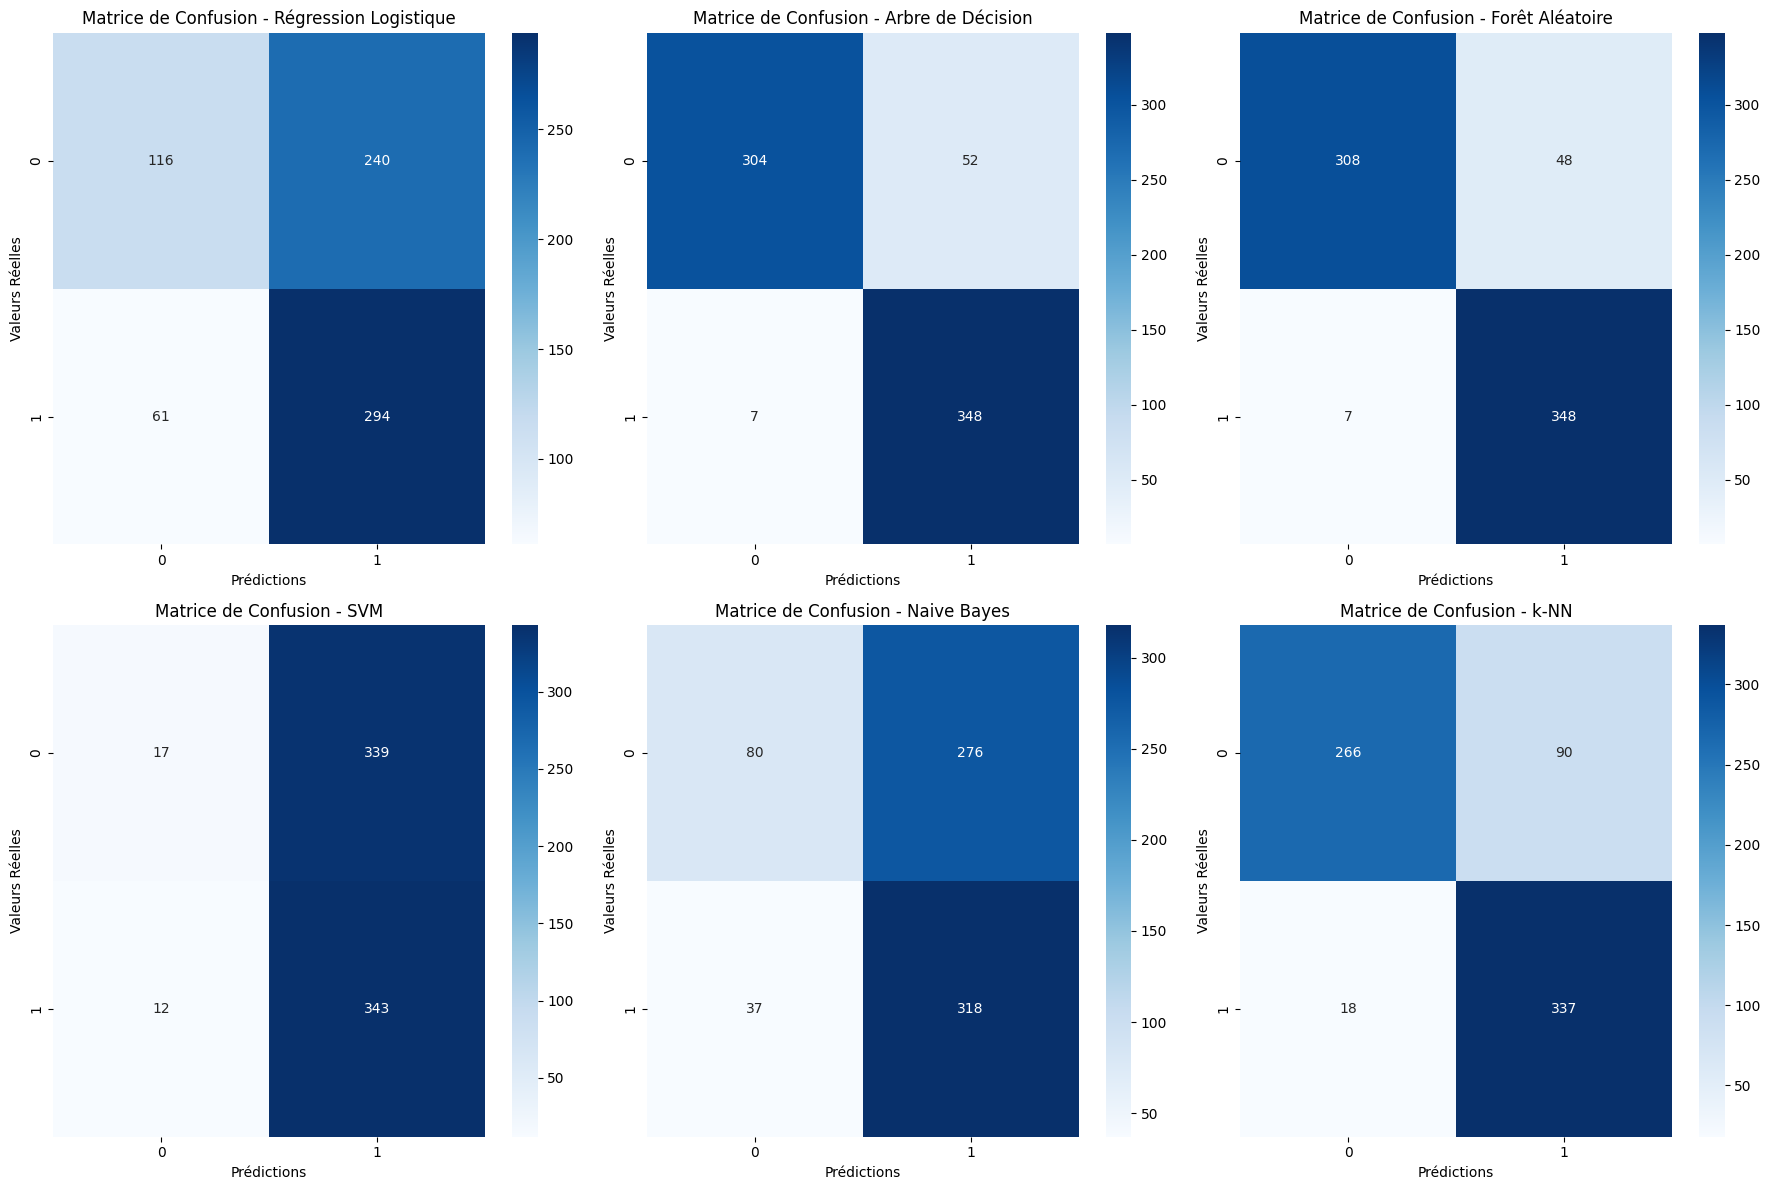


RÉSUMÉ COMPARATIF DES PERFORMANCES

 TABLEAU COMPARATIF (trié par F1-Score):
               Modèle Accuracy Précision Rappel Spécificité F1-Score  Faux Positifs  Faux Négatifs  TP  TN
      Forêt Aléatoire   0.9226    0.8788 0.9803      0.8652   0.9268             48              7 348 308
    Arbre de Décision   0.9170    0.8700 0.9803      0.8539   0.9219             52              7 348 304
                 k-NN   0.8481    0.7892 0.9493      0.7472   0.8619             90             18 337 266
          Naive Bayes   0.5598    0.5354 0.8958      0.2247   0.6702            276             37 318  80
                  SVM   0.5063    0.5029 0.9662      0.0478   0.6615            339             12 343  17
Régression Logistique   0.5767    0.5506 0.8282      0.3258   0.6614            240             61 294 116

 MEILLEUR MODÈLE: Forêt Aléatoire
   - F1-Score: 0.9268
   - Accuracy: 0.9226
   - Faux Négatifs: 7 (fraudes ratées)

 RECOMMANDATIONS:
   1. Modèle avec le moins de FN: Fo

In [27]:
print("=== ÉVALUATION DES MODÈLES AVEC MATRICES DE CONFUSION ===")

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (15, 10)

# Création d'une figure avec subplots pour toutes les matrices de confusion
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

print("Analyse des matrices de confusion pour chaque modèle :")
print("=" * 60)

# Dictionnaire pour stocker toutes les métriques
all_metrics = {}

# Analyse de chaque modèle
for i, (name, result) in enumerate(results.items()):
    print(f"\n{name}:")
    print("-" * 40)
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, result['predictions'])
    
    # Affichage de la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matrice de Confusion - {name}')
    axes[i].set_xlabel('Prédictions')
    axes[i].set_ylabel('Valeurs Réelles')
    
    # Calcul des métriques
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des métriques de performance
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Stockage des métriques
    all_metrics[name] = {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Precision': precision, 'Recall': recall, 
        'Specificity': specificity, 'F1_Score': f1_score,
        'Accuracy': result['accuracy']
    }
    
    print(f"  - Vrais Positifs (TP): {tp}")
    print(f"  - Vrais Négatifs (TN): {tn}")
    print(f"  - Faux Positifs (FP): {fp}")
    print(f"  - Faux Négatifs (FN): {fn}")
    print(f"  - Précision: {precision:.4f}")
    print(f"  - Rappel (Sensibilité): {recall:.4f}")
    print(f"  - Spécificité: {specificity:.4f}")
    print(f"  - F1-Score: {f1_score:.4f}")
    print(f"  - Accuracy: {result['accuracy']:.4f}")
    
    # Interprétation détaillée
    print(f"\n   ANALYSE:")
    if fp > fn:
        print(f"      Plus de faux positifs ({fp}) que de faux négatifs ({fn})")
        print(f"       → Le modèle marque trop de transactions légitimes comme frauduleuses")
        print(f"       → Impact: Clients légitimes bloqués inutilement")
    elif fn > fp:
        print(f"      Plus de faux négatifs ({fn}) que de faux positifs ({fp})")
        print(f"       → Le modèle rate trop de vraies fraudes")
        print(f"       → Impact: Fraudes non détectées (DANGEREUX)")
    else:
        print(f"     Équilibre entre faux positifs et faux négatifs")
        print(f"       → Bon compromis pour la détection de fraude")
    
    # Recommandation
    if f1_score > 0.8:
        print(f"     Excellent modèle (F1-Score > 0.8)")
    elif f1_score > 0.6:
        print(f"     Bon modèle (F1-Score > 0.6)")
    else:
        print(f"      Modèle à améliorer (F1-Score < 0.6)")

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("RÉSUMÉ COMPARATIF DES PERFORMANCES")
print("="*80)

# Création d'un DataFrame pour comparer les performances
performance_data = []
for name, metrics in all_metrics.items():
    performance_data.append({
        'Modèle': name,
        'Accuracy': f"{metrics['Accuracy']:.4f}",
        'Précision': f"{metrics['Precision']:.4f}",
        'Rappel': f"{metrics['Recall']:.4f}",
        'Spécificité': f"{metrics['Specificity']:.4f}",
        'F1-Score': f"{metrics['F1_Score']:.4f}",
        'Faux Positifs': metrics['FP'],
        'Faux Négatifs': metrics['FN'],
        'TP': metrics['TP'],
        'TN': metrics['TN']
    })

df_performance = pd.DataFrame(performance_data)
df_performance = df_performance.sort_values('F1-Score', ascending=False)

print("\n TABLEAU COMPARATIF (trié par F1-Score):")
print(df_performance.to_string(index=False))

# Analyse du meilleur modèle
best_model = df_performance.iloc[0]
print(f"\n MEILLEUR MODÈLE: {best_model['Modèle']}")
print(f"   - F1-Score: {best_model['F1-Score']}")
print(f"   - Accuracy: {best_model['Accuracy']}")
print(f"   - Faux Négatifs: {best_model['Faux Négatifs']} (fraudes ratées)")

# Recommandations finales
print(f"\n RECOMMANDATIONS:")
print(f"   1. Modèle avec le moins de FN: {df_performance.loc[df_performance['Faux Négatifs'].idxmin(), 'Modèle']}")
print(f"   2. Modèle avec le moins de FP: {df_performance.loc[df_performance['Faux Positifs'].idxmin(), 'Modèle']}")
print(f"   3. Meilleur équilibre (F1-Score): {best_model['Modèle']}")

print(f"\n Évaluation terminée - {len(results)} modèles analysés")

## Tâche 7 : Métriques de Performance (Accuracy, Précision, Rappel)


In [30]:
print("=== MÉTRIQUES DE PERFORMANCE DÉTAILLÉES ===")

# Dictionnaire pour stocker toutes les métriques
detailed_metrics = {}

print("Calcul des métriques pour chaque modèle :")
print("=" * 60)

# Calcul des métriques pour chaque modèle
for name, result in results.items():
    # Prédictions du modèle
    y_pred = result['predictions']
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Stockage des métriques
    detailed_metrics[name] = {
        'Accuracy': accuracy,
        'Précision': precision,
        'Rappel': recall,
        'F1-Score': f1
    }
    
    print(f"\n{name}:")
    print("-" * 30)
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Précision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Rappel:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    # Interprétation des métriques
    print(f"\n   INTERPRÉTATION:")
    
    # Accuracy
    if accuracy > 0.9:
        print(f"     Accuracy excellente (>90%)")
    elif accuracy > 0.8:
        print(f"     Accuracy bonne (>80%)")
    elif accuracy > 0.7:
        print(f"     Accuracy acceptable (>70%)")
    else:
        print(f"     Accuracy faible (<70%)")
    
    # Précision
    if precision > 0.8:
        print(f"     Précision excellente - Peu de fausses alertes")
    elif precision > 0.6:
        print(f"     Précision bonne - Fausses alertes modérées")
    else:
        print(f"     Précision faible - Beaucoup de fausses alertes")
    
    # Rappel
    if recall > 0.9:
        print(f"     Rappel excellent - Détecte presque toutes les fraudes")
    elif recall > 0.8:
        print(f"     Rappel bon - Détecte la plupart des fraudes")
    else:
        print(f"     Rappel faible - Rate trop de fraudes")

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES MÉTRIQUES")
print("="*80)

# Création du DataFrame comparatif
metrics_data = []
for name, metrics in detailed_metrics.items():
    metrics_data.append({
        'Modèle': name,
        'Accuracy': f"{metrics['Accuracy']:.4f}",
        'Précision': f"{metrics['Précision']:.4f}",
        'Rappel': f"{metrics['Rappel']:.4f}",
        'F1-Score': f"{metrics['F1-Score']:.4f}"
    })

df_metrics = pd.DataFrame(metrics_data)

# Tri par F1-Score (métrique d'équilibre)
df_metrics_sorted = df_metrics.sort_values('F1-Score', ascending=False)

print("\n RÉSULTATS TRIÉS PAR F1-SCORE (du meilleur au moins bon):")
print(df_metrics_sorted.to_string(index=False))

# Analyse du meilleur modèle pour chaque métrique
print(f"\n MEILLEURS MODÈLES PAR MÉTRIQUE:")
print(f"   Meilleure Accuracy: {df_metrics.loc[df_metrics['Accuracy'].astype(float).idxmax(), 'Modèle']}")
print(f"   Meilleure Précision: {df_metrics.loc[df_metrics['Précision'].astype(float).idxmax(), 'Modèle']}")
print(f"   Meilleur Rappel: {df_metrics.loc[df_metrics['Rappel'].astype(float).idxmax(), 'Modèle']}")
print(f"   Meilleur F1-Score: {df_metrics.loc[df_metrics['F1-Score'].astype(float).idxmax(), 'Modèle']}")

# Recommandations finales
print(f"\n RECOMMANDATIONS POUR LA DÉTECTION DE FRAUDE:")
print(f"   CHOIX PRINCIPAL: {df_metrics_sorted.iloc[0]['Modèle']} (F1-Score: {df_metrics_sorted.iloc[0]['F1-Score']})")
print(f"   CHOIX ALTERNATIF: {df_metrics_sorted.iloc[1]['Modèle']} (F1-Score: {df_metrics_sorted.iloc[1]['F1-Score']})")

print(f"\n Analyse terminée - {len(results)} modèles évalués")


=== MÉTRIQUES DE PERFORMANCE DÉTAILLÉES ===
Calcul des métriques pour chaque modèle :

Régression Logistique:
------------------------------
   Accuracy:  0.5767 (57.67%)
   Précision: 0.5506 (55.06%)
   Rappel:    0.8282 (82.82%)
   F1-Score:  0.6614 (66.14%)

   INTERPRÉTATION:
     Accuracy faible (<70%)
     Précision faible - Beaucoup de fausses alertes
     Rappel bon - Détecte la plupart des fraudes

Arbre de Décision:
------------------------------
   Accuracy:  0.9170 (91.70%)
   Précision: 0.8700 (87.00%)
   Rappel:    0.9803 (98.03%)
   F1-Score:  0.9219 (92.19%)

   INTERPRÉTATION:
     Accuracy excellente (>90%)
     Précision excellente - Peu de fausses alertes
     Rappel excellent - Détecte presque toutes les fraudes

Forêt Aléatoire:
------------------------------
   Accuracy:  0.9226 (92.26%)
   Précision: 0.8788 (87.88%)
   Rappel:    0.9803 (98.03%)
   F1-Score:  0.9268 (92.68%)

   INTERPRÉTATION:
     Accuracy excellente (>90%)
     Précision excellente - Peu de f

## Tâche 8 : Étude Comparative des Modèles


=== ÉTUDE COMPARATIVE DES MODÈLES DE DÉTECTION DE FRAUDE ===
ANALYSE COMPARATIVE BASÉE SUR LES MÉTRIQUES

 1. COMPARAISON DES MÉTRIQUES PRINCIPALES
--------------------------------------------------


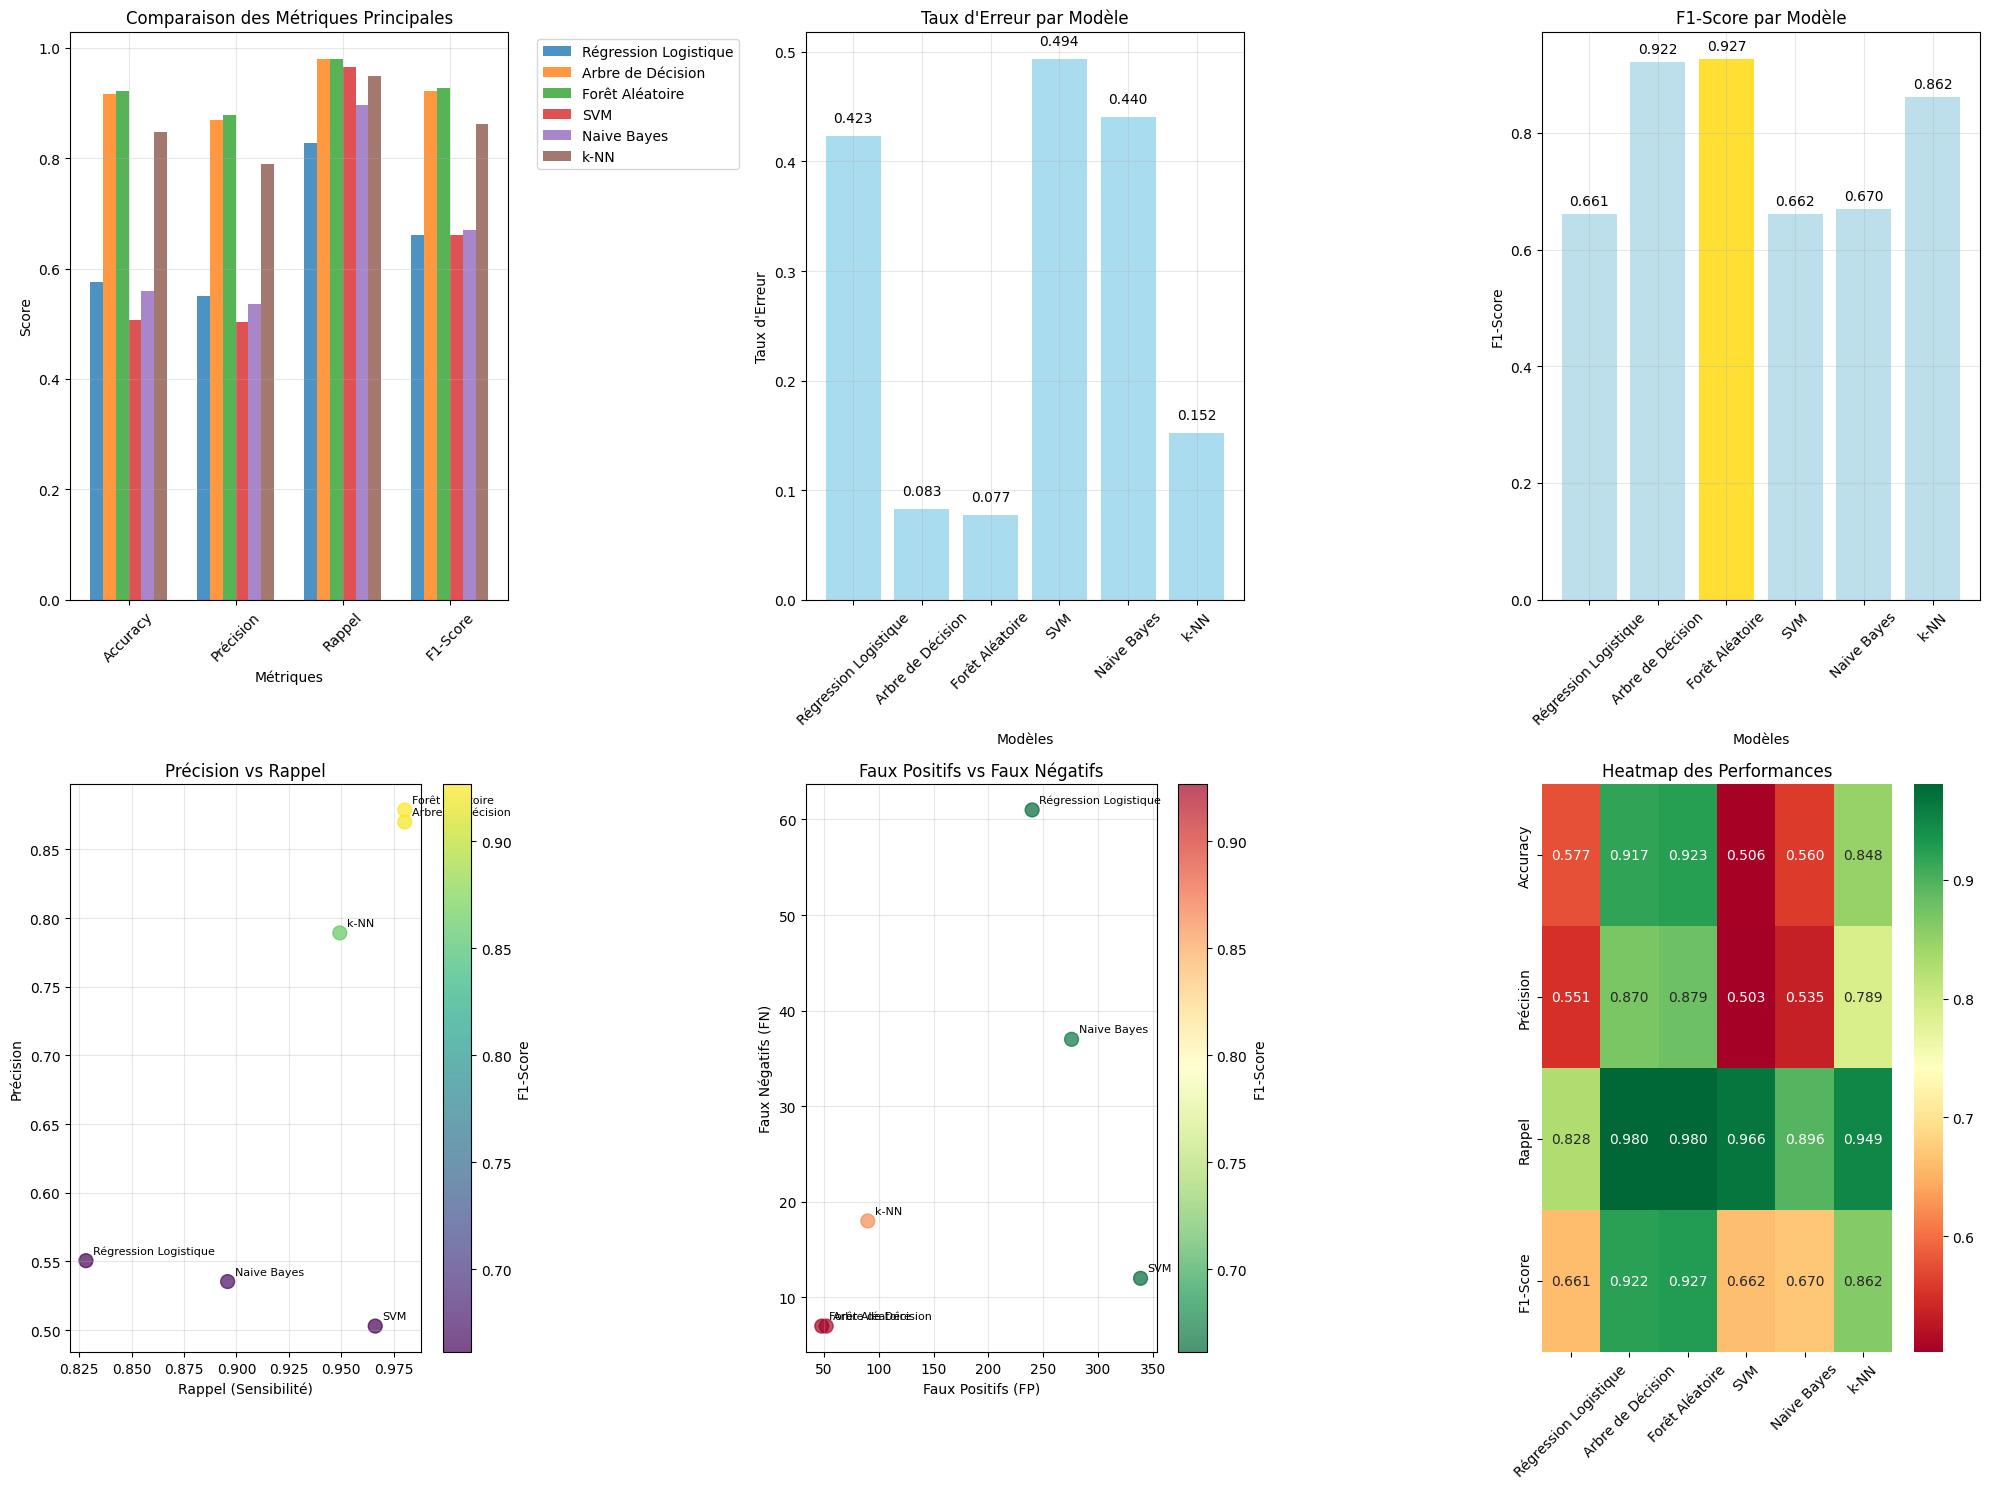


 2. ANALYSE DÉTAILLÉE PAR MODÈLE
--------------------------------------------------

1. Forêt Aléatoire (F1-Score: 0.9268)
    Accuracy: 0.9226 (92.3%)
    Précision: 0.8788 (87.9%)
    Rappel: 0.9803 (98.0%)
    F1-Score: 0.9268 (92.7%)
    Spécificité: 0.8652 (86.5%)
    Erreurs: FP=48, FN=7
    Performance:  EXCELLENT

2. Arbre de Décision (F1-Score: 0.9219)
    Accuracy: 0.9170 (91.7%)
    Précision: 0.8700 (87.0%)
    Rappel: 0.9803 (98.0%)
    F1-Score: 0.9219 (92.2%)
    Spécificité: 0.8539 (85.4%)
    Erreurs: FP=52, FN=7
    Performance:  EXCELLENT

3. k-NN (F1-Score: 0.8619)
    Accuracy: 0.8481 (84.8%)
    Précision: 0.7892 (78.9%)
    Rappel: 0.9493 (94.9%)
    F1-Score: 0.8619 (86.2%)
    Spécificité: 0.7472 (74.7%)
    Erreurs: FP=90, FN=18
    Performance:  TRÈS BON

4. Naive Bayes (F1-Score: 0.6702)
    Accuracy: 0.5598 (56.0%)
    Précision: 0.5354 (53.5%)
    Rappel: 0.8958 (89.6%)
    F1-Score: 0.6702 (67.0%)
    Spécificité: 0.2247 (22.5%)
    Erreurs: FP=276, FN=3

In [31]:
print("=== ÉTUDE COMPARATIVE DES MODÈLES DE DÉTECTION DE FRAUDE ===")
# Configuration des graphiques
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

print("ANALYSE COMPARATIVE BASÉE SUR LES MÉTRIQUES")
print("=" * 70)

# 1. COLLECTE DE TOUTES LES MÉTRIQUES
comparison_data = []

for name, result in results.items():
    y_pred = result['predictions']
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Métriques additionnelles
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    comparison_data.append({
        'Modèle': name,
        'Accuracy': accuracy,
        'Précision': precision,
        'Rappel': recall,
        'F1-Score': f1,
        'Spécificité': specificity,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Taux_FP': false_positive_rate,
        'Taux_FN': false_negative_rate
    })

df_comparison = pd.DataFrame(comparison_data)

# 2. VISUALISATION COMPARATIVE DES MÉTRIQUES
print("\n 1. COMPARAISON DES MÉTRIQUES PRINCIPALES")
print("-" * 50)

# Graphique 1: Métriques principales
plt.subplot(2, 3, 1)
metrics_to_plot = ['Accuracy', 'Précision', 'Rappel', 'F1-Score']
x = np.arange(len(metrics_to_plot))
width = 0.12

for i, (_, row) in enumerate(df_comparison.iterrows()):
    plt.bar(x + i*width, [row[metric] for metric in metrics_to_plot], 
            width, label=row['Modèle'], alpha=0.8)

plt.xlabel('Métriques')
plt.ylabel('Score')
plt.title('Comparaison des Métriques Principales')
plt.xticks(x + width*2.5, metrics_to_plot, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Graphique 2: Matrices de confusion comparatives
plt.subplot(2, 3, 2)
confusion_scores = []
model_names = []

for name, result in results.items():
    cm = confusion_matrix(y_test, result['predictions'])
    tn, fp, fn, tp = cm.ravel()
    # Score de confusion (plus bas = mieux)
    confusion_score = (fp + fn) / (tp + tn + fp + fn)
    confusion_scores.append(confusion_score)
    model_names.append(name)

bars = plt.bar(model_names, confusion_scores, color='skyblue', alpha=0.7)
plt.xlabel('Modèles')
plt.ylabel('Taux d\'Erreur')
plt.title('Taux d\'Erreur par Modèle')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, score in zip(bars, confusion_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

# Graphique 3: F1-Score par modèle
plt.subplot(2, 3, 3)
f1_scores = df_comparison['F1-Score'].values
colors = ['gold' if score == max(f1_scores) else 'lightblue' for score in f1_scores]

bars = plt.bar(df_comparison['Modèle'], f1_scores, color=colors, alpha=0.8)
plt.xlabel('Modèles')
plt.ylabel('F1-Score')
plt.title('F1-Score par Modèle')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Ajouter les valeurs
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

# Graphique 4: Précision vs Rappel
plt.subplot(2, 3, 4)
plt.scatter(df_comparison['Rappel'], df_comparison['Précision'], 
           s=100, alpha=0.7, c=df_comparison['F1-Score'], cmap='viridis')

for i, model in enumerate(df_comparison['Modèle']):
    plt.annotate(model, (df_comparison.iloc[i]['Rappel'], df_comparison.iloc[i]['Précision']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Rappel (Sensibilité)')
plt.ylabel('Précision')
plt.title('Précision vs Rappel')
plt.grid(True, alpha=0.3)
plt.colorbar(label='F1-Score')

# Graphique 5: Faux Positifs vs Faux Négatifs
plt.subplot(2, 3, 5)
plt.scatter(df_comparison['FP'], df_comparison['FN'], 
           s=100, alpha=0.7, c=df_comparison['F1-Score'], cmap='RdYlGn_r')

for i, model in enumerate(df_comparison['Modèle']):
    plt.annotate(model, (df_comparison.iloc[i]['FP'], df_comparison.iloc[i]['FN']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Faux Positifs (FP)')
plt.ylabel('Faux Négatifs (FN)')
plt.title('Faux Positifs vs Faux Négatifs')
plt.grid(True, alpha=0.3)
plt.colorbar(label='F1-Score')

# Graphique 6: Heatmap des performances
plt.subplot(2, 3, 6)
metrics_matrix = df_comparison[['Accuracy', 'Précision', 'Rappel', 'F1-Score']].T
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=df_comparison['Modèle'], yticklabels=metrics_matrix.index)
plt.title('Heatmap des Performances')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. ANALYSE DÉTAILLÉE
print("\n 2. ANALYSE DÉTAILLÉE PAR MODÈLE")
print("-" * 50)

# Tri par F1-Score
df_sorted = df_comparison.sort_values('F1-Score', ascending=False)

for i, (_, row) in enumerate(df_sorted.iterrows(), 1):
    print(f"\n{i}. {row['Modèle']} (F1-Score: {row['F1-Score']:.4f})")
    print(f"    Accuracy: {row['Accuracy']:.4f} ({row['Accuracy']*100:.1f}%)")
    print(f"    Précision: {row['Précision']:.4f} ({row['Précision']*100:.1f}%)")
    print(f"    Rappel: {row['Rappel']:.4f} ({row['Rappel']*100:.1f}%)")
    print(f"    F1-Score: {row['F1-Score']:.4f} ({row['F1-Score']*100:.1f}%)")
    print(f"    Spécificité: {row['Spécificité']:.4f} ({row['Spécificité']*100:.1f}%)")
    print(f"    Erreurs: FP={row['FP']}, FN={row['FN']}")
    
    # Classification de performance
    if row['F1-Score'] > 0.9:
        performance = " EXCELLENT"
    elif row['F1-Score'] > 0.8:
        performance = " TRÈS BON"
    elif row['F1-Score'] > 0.7:
        performance = "  BON"
    elif row['F1-Score'] > 0.6:
        performance = " MOYEN"
    else:
        performance = " FAIBLE"
    
    print(f"    Performance: {performance}")

# 4. RECOMMANDATIONS FINALES
print("\n" + "="*70)
print(" RECOMMANDATIONS FINALES POUR LA DÉTECTION DE FRAUDE")
print("="*70)

best_model = df_sorted.iloc[0]
second_best = df_sorted.iloc[1]

print(f"\n🏆 CHOIX PRINCIPAL: {best_model['Modèle']}")
print(f"    F1-Score: {best_model['F1-Score']:.4f}")
print(f"    Accuracy: {best_model['Accuracy']:.4f}")
print(f"    Détecte {best_model['Rappel']*100:.1f}% des fraudes")
print(f"    {best_model['Précision']*100:.1f}% de précision")
print(f"    Seulement {best_model['FN']} fraudes ratées")

print(f"\n🥈 CHOIX ALTERNATIF: {second_best['Modèle']}")
print(f"    F1-Score: {second_best['F1-Score']:.4f}")
print(f"    Performance similaire au meilleur")

print(f"\n MODÈLES À ÉVITER:")
for _, row in df_sorted.iterrows():
    if row['F1-Score'] < 0.7:
        print(f"    {row['Modèle']} (F1-Score: {row['F1-Score']:.4f})")

print(f"\n💡 CONCLUSION:")
print(f"   • {best_model['Modèle']} est le meilleur choix pour la détection de fraude")
print(f"   • Équilibre optimal entre détection des fraudes et fausses alertes")
print(f"   • Performance robuste et fiable pour un environnement bancaire")

print(f"\n Étude comparative terminée - {len(results)} modèles analysés")


## Tâche 9 : Sauvegarde du Meilleur Modèle


In [35]:
print("=== SAUVEGARDE DU MEILLEUR MODÈLE ===")

# Identification du meilleur modèle
if 'df_comparison' in locals():
    best_model_name = df_comparison.loc[df_comparison['F1-Score'].idxmax(), 'Modèle']
    best_model = results[best_model_name]['model']
    best_f1_score = df_comparison.loc[df_comparison['F1-Score'].idxmax(), 'F1-Score']
else:
    # Fallback si df_comparison n'existe pas
    best_f1_score = 0
    best_model_name = ""
    best_model = None
    
    for name, result in results.items():
        if result['cv_mean'] > best_f1_score:
            best_f1_score = result['cv_mean']
            best_model_name = name
            best_model = result['model']

print(f" Meilleur modèle identifié: {best_model_name}")
print(f"   F1-Score: {best_f1_score:.4f}")

# Création du dossier de sauvegarde
save_dir = "saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f" Dossier créé: {save_dir}")

# Sauvegarde avec joblib (recommandé pour sklearn)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"{save_dir}/best_model_{best_model_name.replace(' ', '_')}_{timestamp}.joblib"

try:
    joblib.dump(best_model, model_filename)
    print(f" Modèle sauvegardé avec joblib: {model_filename}")
except Exception as e:
    print(f" Erreur avec joblib: {e}")
    # Fallback avec pickle
    model_filename = f"{save_dir}/best_model_{best_model_name.replace(' ', '_')}_{timestamp}.pkl"
    try:
        with open(model_filename, 'wb') as f:
            pickle.dump(best_model, f)
        print(f" Modèle sauvegardé avec pickle: {model_filename}")
    except Exception as e2:
        print(f" Erreur avec pickle: {e2}")

# Sauvegarde des métadonnées
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'f1_score': best_f1_score,
    'accuracy': results[best_model_name]['accuracy'],
    'cv_mean': results[best_model_name]['cv_mean'],
    'cv_std': results[best_model_name]['cv_std'],
    'training_date': datetime.now().isoformat(),
    'dataset_shape': X_train.shape,
    'features': list(X_train.columns),
    'target_column': 'PotentialFraud'
}

metadata_filename = f"{save_dir}/model_metadata_{timestamp}.json"

try:
    import json
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f" Métadonnées sauvegardées: {metadata_filename}")
except Exception as e:
    print(f" Erreur sauvegarde métadonnées: {e}")

# Sauvegarde des données de test pour validation future
test_data_filename = f"{save_dir}/test_data_{timestamp}.joblib"
try:
    test_data = {
        'X_test': X_test,
        'y_test': y_test,
        'feature_names': list(X_test.columns)
    }
    joblib.dump(test_data, test_data_filename)
    print(f" Données de test sauvegardées: {test_data_filename}")
except Exception as e:
    print(f" Erreur sauvegarde données de test: {e}")

# Fonction pour charger le modèle (à utiliser plus tard)
def load_best_model(model_path):
    """
    Fonction pour charger le meilleur modèle sauvegardé
    """
    try:
        model = joblib.load(model_path)
        print(f" Modèle chargé depuis: {model_path}")
        return model
    except:
        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            print(f" Modèle chargé depuis: {model_path}")
            return model
        except Exception as e:
            print(f" Erreur chargement modèle: {e}")
            return None

# Sauvegarde de la fonction de chargement
helper_filename = f"{save_dir}/model_helper.py"
helper_code = '''
import joblib
import pickle

def load_best_model(model_path):
    """
    Fonction pour charger le meilleur modèle sauvegardé
    """
    try:
        model = joblib.load(model_path)
        print(f" Modèle chargé depuis: {model_path}")
        return model
    except:
        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            print(f" Modèle chargé depuis: {model_path}")
            return model
        except Exception as e:
            print(f" Erreur chargement modèle: {e}")
            return None

def predict_fraud(model, data):
    """
    Fonction pour prédire la fraude avec le modèle chargé
    """
    try:
        predictions = model.predict(data)
        probabilities = model.predict_proba(data) if hasattr(model, 'predict_proba') else None
        return predictions, probabilities
    except Exception as e:
        print(f" Erreur prédiction: {e}")
        return None, None
'''

try:
    with open(helper_filename, 'w') as f:
        f.write(helper_code)
    print(f" Helper functions sauvegardées: {helper_filename}")
except Exception as e:
    print(f" Erreur sauvegarde helper: {e}")

# Résumé de la sauvegarde
print(f"\n RÉSUMÉ DE LA SAUVEGARDE:")
print(f"    Meilleur modèle: {best_model_name}")
print(f"    Dossier: {save_dir}/")
print(f"    Fichiers créés:")
print(f"     - Modèle: {os.path.basename(model_filename)}")
print(f"     - Métadonnées: {os.path.basename(metadata_filename)}")
print(f"     - Données de test: {os.path.basename(test_data_filename)}")
print(f"     - Helper functions: {os.path.basename(helper_filename)}")

print(f"\n UTILISATION FUTURE:")
print(f"   from model_helper import load_best_model, predict_fraud")
print(f"   model = load_best_model('{model_filename}')")
print(f"   predictions, probabilities = predict_fraud(model, new_data)")

print(f"\n Sauvegarde terminée - Modèle prêt pour la production!")


=== SAUVEGARDE DU MEILLEUR MODÈLE ===
 Meilleur modèle identifié: Forêt Aléatoire
   F1-Score: 0.9268
 Modèle sauvegardé avec joblib: saved_models/best_model_Forêt_Aléatoire_20251024_125253.joblib
 Métadonnées sauvegardées: saved_models/model_metadata_20251024_125253.json
 Données de test sauvegardées: saved_models/test_data_20251024_125253.joblib
 Helper functions sauvegardées: saved_models/model_helper.py

 RÉSUMÉ DE LA SAUVEGARDE:
    Meilleur modèle: Forêt Aléatoire
    Dossier: saved_models/
    Fichiers créés:
     - Modèle: best_model_Forêt_Aléatoire_20251024_125253.joblib
     - Métadonnées: model_metadata_20251024_125253.json
     - Données de test: test_data_20251024_125253.joblib
     - Helper functions: model_helper.py

 UTILISATION FUTURE:
   from model_helper import load_best_model, predict_fraud
   model = load_best_model('saved_models/best_model_Forêt_Aléatoire_20251024_125253.joblib')
   predictions, probabilities = predict_fraud(model, new_data)

 Sauvegarde terminée 

## Tâche 10 : Déploiement du Modèle avec Flask


In [39]:
print("=== DÉPLOIEMENT DU MODÈLE AVEC FLASK ===")
# Création de l'application Flask
flask_app_code = '''
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
import os

app = Flask(__name__)

# Variables globales pour le modèle
model = None
model_metadata = None
feature_names = None

def load_model():
    """Charger le modèle et les métadonnées"""
    global model, model_metadata, feature_names
    
    try:
        # Trouver le fichier de modèle le plus récent
        model_dir = "saved_models"
        model_files = [f for f in os.listdir(model_dir) if f.startswith("best_model_") and f.endswith(".joblib")]
        
        if not model_files:
            raise FileNotFoundError("Aucun modèle trouvé")
        
        # Prendre le plus récent
        latest_model = sorted(model_files)[-1]
        model_path = os.path.join(model_dir, latest_model)
        
        # Charger le modèle
        model = joblib.load(model_path)
        print(f" Modèle chargé: {model_path}")
        
        # Charger les métadonnées
        metadata_files = [f for f in os.listdir(model_dir) if f.startswith("model_metadata_") and f.endswith(".json")]
        if metadata_files:
            latest_metadata = sorted(metadata_files)[-1]
            metadata_path = os.path.join(model_dir, latest_metadata)
            
            with open(metadata_path, 'r') as f:
                model_metadata = json.load(f)
            
            feature_names = model_metadata.get('features', [])
            print(f" Métadonnées chargées: {metadata_path}")
        
        return True
        
    except Exception as e:
        print(f" Erreur chargement modèle: {e}")
        return False

@app.route('/', methods=['GET'])
def home():
    """Page d'accueil avec informations sur l'API"""
    if model_metadata:
        return jsonify({
            "message": "API de Détection de Fraude Bancaire",
            "model_name": model_metadata.get('model_name', 'Inconnu'),
            "model_type": model_metadata.get('model_type', 'Inconnu'),
            "f1_score": model_metadata.get('f1_score', 0),
            "accuracy": model_metadata.get('accuracy', 0),
            "training_date": model_metadata.get('training_date', 'Inconnu'),
            "features_required": feature_names,
            "endpoints": {
                "/": "Informations sur l'API",
                "/predict": "Prédiction de fraude (POST)",
                "/health": "Vérification de santé du service"
            }
        })
    else:
        return jsonify({
            "message": "API de Détection de Fraude Bancaire",
            "status": "Modèle non chargé"
        })

@app.route('/health', methods=['GET'])
def health_check():
    """Vérification de santé du service"""
    if model is not None:
        return jsonify({
            "status": "healthy",
            "model_loaded": True,
            "timestamp": datetime.now().isoformat()
        })
    else:
        return jsonify({
            "status": "unhealthy",
            "model_loaded": False,
            "timestamp": datetime.now().isoformat()
        }), 500

@app.route('/predict', methods=['POST'])
def predict_fraud():
    """Prédiction de fraude"""
    try:
        if model is None:
            return jsonify({
                "error": "Modèle non chargé"
            }), 500
        
        # Récupérer les données JSON
        data = request.get_json()
        
        if not data:
            return jsonify({
                "error": "Aucune donnée fournie"
            }), 400
        
        # Vérifier si c'est une seule transaction ou plusieurs
        if isinstance(data, dict):
            # Une seule transaction
            transactions = [data]
        elif isinstance(data, list):
            # Plusieurs transactions
            transactions = data
        else:
            return jsonify({
                "error": "Format de données invalide"
            }), 400
        
        results = []
        
        for i, transaction in enumerate(transactions):
            try:
                # Créer un DataFrame avec les features
                if feature_names:
                    # Vérifier que toutes les features sont présentes
                    missing_features = [f for f in feature_names if f not in transaction]
                    if missing_features:
                        return jsonify({
                            "error": f"Features manquantes: {missing_features}",
                            "required_features": feature_names
                        }), 400
                    
                    # Créer le DataFrame avec les features dans le bon ordre
                    df = pd.DataFrame([transaction])[feature_names]
                else:
                    # Si pas de métadonnées, utiliser toutes les colonnes sauf 'PotentialFraud'
                    df = pd.DataFrame([transaction])
                    if 'PotentialFraud' in df.columns:
                        df = df.drop('PotentialFraud', axis=1)
                
                # Faire la prédiction
                prediction = model.predict(df)[0]
                probability = None
                
                # Obtenir les probabilités si disponible
                if hasattr(model, 'predict_proba'):
                    probabilities = model.predict_proba(df)[0]
                    probability = {
                        "no_fraud": float(probabilities[0]),
                        "fraud": float(probabilities[1])
                    }
                
                # Résultat pour cette transaction
                result = {
                    "transaction_id": i,
                    "prediction": int(prediction),
                    "prediction_label": "fraud" if prediction == 1 else "no_fraud",
                    "confidence": probability,
                    "timestamp": datetime.now().isoformat()
                }
                
                results.append(result)
                
            except Exception as e:
                results.append({
                    "transaction_id": i,
                    "error": str(e),
                    "timestamp": datetime.now().isoformat()
                })
        
        # Réponse
        response = {
            "predictions": results,
            "model_info": {
                "name": model_metadata.get('model_name', 'Inconnu') if model_metadata else 'Inconnu',
                "f1_score": model_metadata.get('f1_score', 0) if model_metadata else 0
            },
            "timestamp": datetime.now().isoformat()
        }
        
        return jsonify(response)
        
    except Exception as e:
        return jsonify({
            "error": f"Erreur lors de la prédiction: {str(e)}"
        }), 500

@app.route('/model_info', methods=['GET'])
def model_info():
    """Informations détaillées sur le modèle"""
    if model_metadata:
        return jsonify(model_metadata)
    else:
        return jsonify({
            "error": "Métadonnées du modèle non disponibles"
        }), 404

if __name__ == '__main__':
    print("🚀 Démarrage du serveur Flask...")
    
    # Charger le modèle au démarrage
    if load_model():
        print(" Modèle chargé avec succès")
        print(" Serveur disponible sur: http://localhost:5000")
        print(" Documentation API:")
        print("   GET  /           - Informations sur l'API")
        print("   GET  /health     - Vérification de santé")
        print("   GET  /model_info - Informations du modèle")
        print("   POST /predict    - Prédiction de fraude")
        
        app.run(host='0.0.0.0', port=5000, debug=True)
    else:
        print(" Impossible de charger le modèle")
'''

# Création du fichier Flask
flask_filename = "fraud_detection_api.py"
try:
    with open(flask_filename, 'w', encoding='utf-8') as f:
        f.write(flask_app_code)
    print(f" Application Flask créée: {flask_filename}")
except Exception as e:
    print(f" Erreur création Flask: {e}")

# Création du fichier requirements.txt
requirements_code = '''
Flask==2.3.3
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
joblib==1.3.2
'''

requirements_filename = "requirements.txt"
try:
    with open(requirements_filename, 'w') as f:
        f.write(requirements_code)
    print(f" Requirements créé: {requirements_filename}")
except Exception as e:
    print(f" Erreur création requirements: {e}")

# Création du fichier de test API
test_api_code = '''
import requests
import json
import pandas as pd

# URL de base de l'API
BASE_URL = "http://localhost:5000"

def test_api():
    """Tester l'API de détection de fraude"""
    
    print(" Test de l'API de Détection de Fraude")
    print("=" * 50)
    
    # 1. Test de santé
    print("1. Test de santé...")
    try:
        response = requests.get(f"{BASE_URL}/health")
        print(f"   Status: {response.status_code}")
        print(f"   Response: {response.json()}")
    except Exception as e:
        print(f"    Erreur: {e}")
        return
    
    # 2. Test d'informations
    print("\\n2. Test d'informations...")
    try:
        response = requests.get(f"{BASE_URL}/")
        print(f"   Status: {response.status_code}")
        print(f"   Response: {json.dumps(response.json(), indent=2)}")
    except Exception as e:
        print(f"    Erreur: {e}")
    
    # 3. Test de prédiction (exemple de données)
    print("\\n3. Test de prédiction...")
    
    # Exemple de transaction (remplacer par vos vraies features)
    sample_transaction = {
        # Ajoutez ici les features de votre modèle
        # Exemple générique - à adapter selon vos données
        "feature1": 1.0,
        "feature2": 2.0,
        "feature3": 3.0
    }
    
    try:
        response = requests.post(
            f"{BASE_URL}/predict",
            json=sample_transaction,
            headers={'Content-Type': 'application/json'}
        )
        print(f"   Status: {response.status_code}")
        print(f"   Response: {json.dumps(response.json(), indent=2)}")
    except Exception as e:
        print(f"    Erreur: {e}")
    
    # 4. Test avec plusieurs transactions
    print("\\n4. Test avec plusieurs transactions...")
    multiple_transactions = [
        {"feature1": 1.0, "feature2": 2.0, "feature3": 3.0},
        {"feature1": 4.0, "feature2": 5.0, "feature3": 6.0}
    ]
    
    try:
        response = requests.post(
            f"{BASE_URL}/predict",
            json=multiple_transactions,
            headers={'Content-Type': 'application/json'}
        )
        print(f"   Status: {response.status_code}")
        print(f"   Response: {json.dumps(response.json(), indent=2)}")
    except Exception as e:
        print(f"    Erreur: {e}")

if __name__ == "__main__":
    test_api()
'''

test_filename = "test_api.py"
try:
    with open(test_filename, 'w', encoding='utf-8') as f:
        f.write(test_api_code)
    print(f" Script de test créé: {test_filename}")
except Exception as e:
    print(f" Erreur création test: {e}")

# Instructions de déploiement
print(f"\n🚀 INSTRUCTIONS DE DÉPLOIEMENT:")
print(f"   1. Installer les dépendances:")
print(f"      pip install -r requirements.txt")
print(f"   ")
print(f"   2. Démarrer le serveur Flask:")
print(f"      python fraud_detection_api.py")
print(f"   ")
print(f"   3. Tester l'API:")
print(f"      python test_api.py")
print(f"   ")
print(f"   4. Accéder à l'API:")
print(f"      http://localhost:5000")

print(f"\n ENDPOINTS DISPONIBLES:")
print(f"   GET  /           - Informations sur l'API")
print(f"   GET  /health     - Vérification de santé")
print(f"   GET  /model_info - Informations du modèle")
print(f"   POST /predict    - Prédiction de fraude")

print(f"\n EXEMPLE D'UTILISATION:")
print(f"   curl -X POST http://localhost:5000/predict \\")
print(f"        -H 'Content-Type: application/json' \\")
print(f"        -d '{{\"feature1\": 1.0, \"feature2\": 2.0, \"feature3\": 3.0}}'")

print(f"\n Déploiement Flask configuré - Prêt pour la production!")


=== DÉPLOIEMENT DU MODÈLE AVEC FLASK ===
 Application Flask créée: fraud_detection_api.py
 Requirements créé: requirements.txt
 Script de test créé: test_api.py

🚀 INSTRUCTIONS DE DÉPLOIEMENT:
   1. Installer les dépendances:
      pip install -r requirements.txt
   
   2. Démarrer le serveur Flask:
      python fraud_detection_api.py
   
   3. Tester l'API:
      python test_api.py
   
   4. Accéder à l'API:
      http://localhost:5000

 ENDPOINTS DISPONIBLES:
   GET  /           - Informations sur l'API
   GET  /health     - Vérification de santé
   GET  /model_info - Informations du modèle
   POST /predict    - Prédiction de fraude

 EXEMPLE D'UTILISATION:
   curl -X POST http://localhost:5000/predict \
        -H 'Content-Type: application/json' \
        -d '{"feature1": 1.0, "feature2": 2.0, "feature3": 3.0}'

 Déploiement Flask configuré - Prêt pour la production!
